# MLflow + whylogs Integration

In this notebook, we will explore the [MLflow](https://mlflow.org/) integration in `whylogs`.

This example uses the data from [MLflow's tutorial](https://mlflow.org/docs/latest/tutorials-and-examples/tutorial.html) for demonstration purposes.

This tutorial showcases how you can use the whylogs integration to:
* Capture data quality metrics while training a linear regression model in `mlflow`
* Extract whylogs data back into an in-memory format from the MLflow backend
* Visualize this data

# Getting Started
To run this tutorial:
* Install [conda](https://conda.io/projects/conda/en/latest/user-guide/install/index.html)
* Create a new environment with conda via `conda create --name whylogs-mlflow python=3.8`
    * You'll need to activate the environment with `conda activate whylogs-mlflow`
    * You'll need to install pip into the Conda environment `conda install pip`
    * To make the environment work with Jupyter notebooks, run `pip install ipykernel` to install the kernel module
    * Install the environment as a Jupyter notebook kernel via `python -m ipykernel install --user --name=whylogs-mlflow`
* Install MLflow with scikit-learn via `pip install mlflow[extras]`
* Install whylogs with matplotlib via `pip install whylogs[viz]`
* You can also install the necessary libraries separately:
    * MLflow: `pip install mlflow`
    * whylogs: `pip install whylogs`
    * scikit-learn: `pip install scikit-learn`
    * matplotlib: `pip install matplotlib`
* In your notebook, ensure you select `whylogs-mlflow` as your kernel

# Setup
First, we want to filter out noisy warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')


In [2]:
import random
import time

import pandas as pd
import mlflow
import whylogs

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet

# Enable whylogs Integration

Enable whylogs in MLflow to allow storing whylogs statistical profiles with every run. This method returns `True` if whylogs is able to patch MLflow.

In [3]:
assert whylogs.__version__ >= "0.1.13" # we need 0.1.13 or later for MLflow integration
whylogs.enable_mlflow()

True

# Dataset Preparation

Download and prepare the UCI wine quality dataset. We sample the test dataset further to represent batches of data produced every second.

In [4]:
data_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(data_url, sep=";")
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [5]:
# Split the data into training and test sets
train, test = train_test_split(data)

We can quickly get a sense of the shape of the training dataset by profiling it with whylogs. Later, we can compare the baseline data metrics to the profiles of the batches as they flow through our model.

If you'd like to learn more about whylogs, check out our [introductory notebook](https://github.com/whylabs/whylogs-examples/blob/mainline/python/GettingStarted.ipynb).

In [6]:
from whylogs import get_or_create_session

with get_or_create_session() as session:
    summary = session.profile_dataframe(train, "training-data").flat_summary()['summary']

summary

,column,count,null_count,bool_count,numeric_count,max,mean,min,stddev,nunique_numbers,...,nunique_str_upper,quantile_0.0000,quantile_0.0100,quantile_0.0500,quantile_0.2500,quantile_0.5000,quantile_0.7500,quantile_0.9500,quantile_0.9900,quantile_1.0000
0,chlorides,1199.0,0.0,0.0,1199.0,0.61100,0.086965,0.01200,0.044101,134.0,...,0.0,0.01200,0.04100,0.05400,0.07000,0.07900,0.0900,0.123,0.3680,0.61100
1,quality,1199.0,0.0,0.0,1199.0,8.00000,5.626355,3.00000,0.785196,6.0,...,0.0,3.00000,4.00000,5.00000,5.00000,6.00000,6.0000,7.000,8.0000,8.00000
2,total sulfur dioxide,1199.0,0.0,0.0,1199.0,289.00000,46.488741,6.00000,33.239143,141.0,...,0.0,6.00000,8.00000,11.00000,22.00000,37.00000,63.0000,115.000,148.0000,289.00000
3,alcohol,1199.0,0.0,0.0,1199.0,14.90000,10.404393,8.40000,1.060160,65.0,...,0.0,8.40000,9.00000,9.20000,9.50000,10.10000,11.0000,12.500,13.4000,14.90000
4,density,1199.0,0.0,0.0,1199.0,1.00369,0.996796,0.99007,0.001863,390.0,...,0.0,0.99007,0.99235,0.99362,0.99566,0.99677,0.9979,1.000,1.0022,1.00369
5,free sulfur dioxide,1199.0,0.0,0.0,1199.0,72.00000,15.822769,1.00000,10.503918,57.0,...,0.0,1.00000,3.00000,4.00000,7.00000,13.00000,21.0000,35.000,48.0000,72.00000
6,volatile acidity,1199.0,0.0,0.0,1199.0,1.33000,0.530367,0.12000,0.178894,136.0,...,0.0,0.12000,0.18000,0.27000,0.40000,0.53000,0.6400,0.855,1.0350,1.33000
7,sulphates,1199.0,0.0,0.0,1199.0,1.98000,0.657131,0.33000,0.168270,89.0,...,0.0,0.33000,0.43000,0.47000,0.55000,0.62000,0.7300,0.950,1.3400,1.98000
8,citric acid,1199.0,0.0,0.0,1199.0,0.78000,0.269700,0.00000,0.193572,75.0,...,0.0,0.00000,0.00000,0.00000,0.09000,0.26000,0.4200,0.600,0.6900,0.78000
9,pH,1199.0,0.0,0.0,1199.0,4.01000,3.310234,2.89000,0.153440,82.0,...,0.0,2.89000,2.93000,3.06000,3.21000,3.31000,3.4000,3.560,3.6800,4.01000


Now that we've taken a peek at our training data metrics, there's one last item on our to-do list: split the test data into batches, so we can feed them through our model later on.

In [7]:
# Relocate predicted variable "quality" to y vectors
train_x = train.drop(["quality"], axis=1).reset_index(drop=True)
test_x = test.drop(["quality"], axis=1).reset_index(drop=True)
train_y = train[["quality"]].reset_index(drop=True)
test_y = test[["quality"]].reset_index(drop=True)

subset_test_x = []
subset_test_y = []
num_batches = 20
for i in range(num_batches):
    indices = random.sample(range(len(test)), 5)
    subset_test_x.append(test_x.loc[indices, :])
    subset_test_y.append(test_y.loc[indices, :])

# Train the model
We'll train an ElasticNet model using scikit-learn, then run this model for each of the batches of data, logging the model parameters, mean absolute error, and whylogs data metrics.

Note that whylogs profiler data is automatically logged when `mlflow.end_run()` is called (implicitly or explicitly).

In [8]:
# Create an MLflow experiment for our demo
experiment_name = "whylogs demo"
mlflow.set_experiment(experiment_name)

model_params = {"alpha": 1.0,
                "l1_ratio": 0.7}

lr = ElasticNet(**model_params)
lr.fit(train_x, train_y)
print("ElasticNet model (%s):" % model_params)

INFO: 'whylogs demo' does not exist. Creating a new experiment
ElasticNet model ({'alpha': 1.0, 'l1_ratio': 0.7}):


In [9]:
# run predictions on the batches of data we set up earlier and log whylogs data
for i in range(num_batches):
    with mlflow.start_run(run_name=f"Run {i+1}"):
        batch = subset_test_x[i]
        predicted_output = lr.predict(batch)

        mae = mean_absolute_error(subset_test_y[i], predicted_output)
        print("Subset %.0f, mean absolute error: %s" % (i + 1, mae))

        mlflow.log_params(model_params)
        mlflow.log_metric("mae", mae)

        # use whylogs to log data quality metrics for the current batch
        mlflow.whylogs.log_pandas(batch)

    # wait a second between runs to create a time series of prediction results
    time.sleep(1)

Subset 1, mean absolute error: 0.5789794874388365
Subset 2, mean absolute error: 0.6111029246160566
Subset 3, mean absolute error: 0.8536210353690337
Subset 4, mean absolute error: 1.0097638903189077
Subset 5, mean absolute error: 1.1419334387935294
Subset 6, mean absolute error: 0.4389454235595741
Subset 7, mean absolute error: 0.6943716888788721
Subset 8, mean absolute error: 0.5281415556056386
Subset 9, mean absolute error: 0.8662166919084389
Subset 10, mean absolute error: 0.8462118256399723
Subset 11, mean absolute error: 0.9189648886334384
Subset 12, mean absolute error: 0.6721440596916878
Subset 13, mean absolute error: 0.8699212967729693
Subset 14, mean absolute error: 0.7364127140011986
Subset 15, mean absolute error: 0.8105048112918138
Subset 16, mean absolute error: 0.5930083232393926
Subset 17, mean absolute error: 0.6795532694207491
Subset 18, mean absolute error: 0.38086797237556774
Subset 19, mean absolute error: 0.7352651500373737
Subset 20, mean absolute error: 0.62620

# Accessing whylogs Data From Your Experiment
Now, let's explore our whylogs data inside the MLflow experiment.

In [10]:
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name(experiment_name)
experiment.name, experiment.experiment_id

('whylogs demo', '1')

MLflow stores the data profiles as *artifacts*. These can be retrieved in the same way you access MLflow projects, parameters, and metrics.

whylogs exposes helper API for accessing whylogs-specific output of an experiment.

In [11]:
whylogs.mlflow.list_whylogs_runs(experiment.experiment_id)

[<RunInfo: artifact_uri='file:///Users/alex/Code/whylogs-examples/python/mlruns/1/964c5ebd92904c5fb26d86d4a7ff90eb/artifacts', end_time=1612491706925, experiment_id='1', lifecycle_stage='active', run_id='964c5ebd92904c5fb26d86d4a7ff90eb', run_uuid='964c5ebd92904c5fb26d86d4a7ff90eb', start_time=1612491706903, status='FINISHED', user_id='alex'>,
 <RunInfo: artifact_uri='file:///Users/alex/Code/whylogs-examples/python/mlruns/1/1b3f6274772a464cb1e81d860dd7ff7e/artifacts', end_time=1612491705899, experiment_id='1', lifecycle_stage='active', run_id='1b3f6274772a464cb1e81d860dd7ff7e', run_uuid='1b3f6274772a464cb1e81d860dd7ff7e', start_time=1612491705876, status='FINISHED', user_id='alex'>,
 <RunInfo: artifact_uri='file:///Users/alex/Code/whylogs-examples/python/mlruns/1/8c3130a637d846eebede052e3bb2d1cf/artifacts', end_time=1612491704870, experiment_id='1', lifecycle_stage='active', run_id='8c3130a637d846eebede052e3bb2d1cf', run_uuid='8c3130a637d846eebede052e3bb2d1cf', start_time=1612491704847

# Visualizing whylogs Data
Our integration allows you to quickly collect the statistical profiles produced during experimentation.

In [12]:
mlflow_profiles = whylogs.mlflow.get_experiment_profiles(experiment.experiment_id)
mlflow_profiles

You can then use `whylogs.viz` to easily produce visualizations for the whylogs profile data.

Below, you can see how the data changed over time in our batches for the column called `free sulfur dioxide`.

In [13]:
from whylogs.viz import ProfileVisualizer

viz = ProfileVisualizer()
viz.set_profiles(mlflow_profiles)

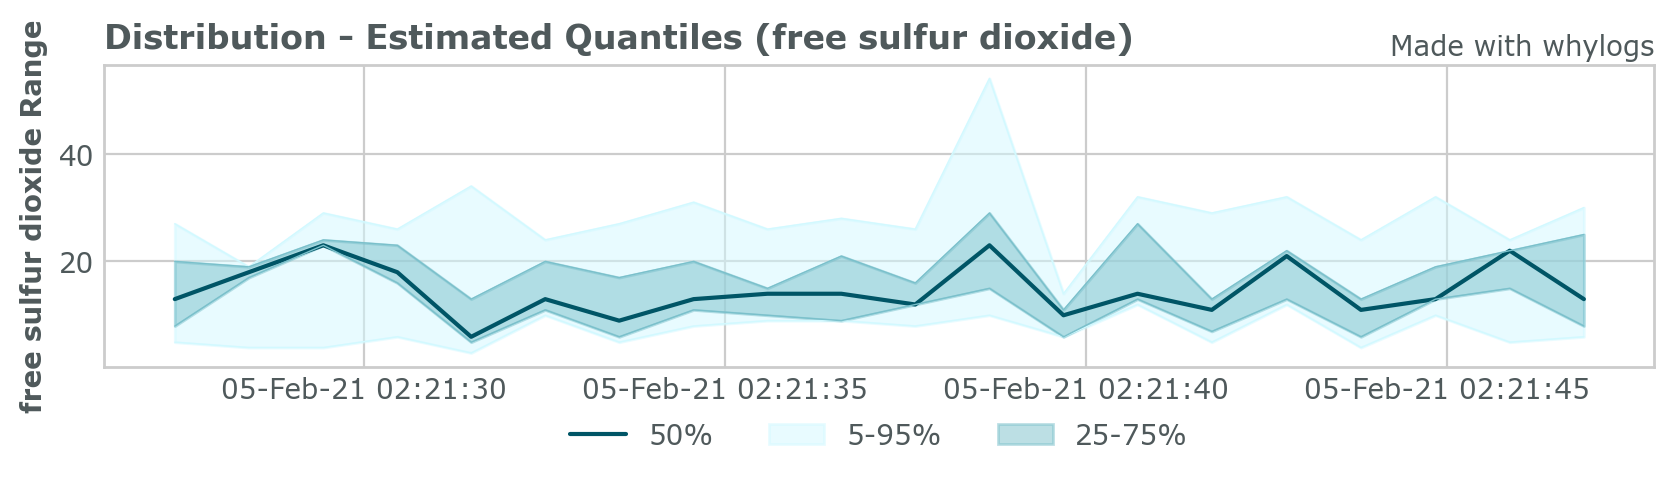

In [14]:
viz.plot_distribution("free sulfur dioxide", ts_format="%d-%b-%y %H:%M:%S")

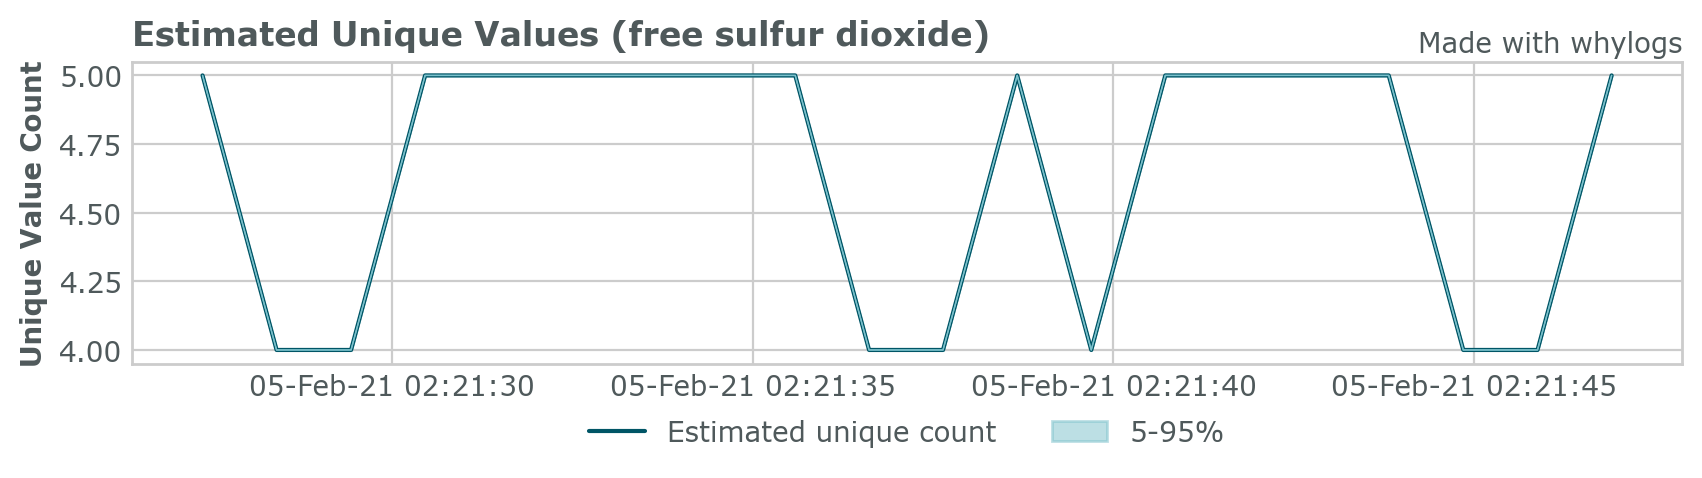

In [15]:
viz.plot_uniqueness("free sulfur dioxide", ts_format="%d-%b-%y %H:%M:%S")

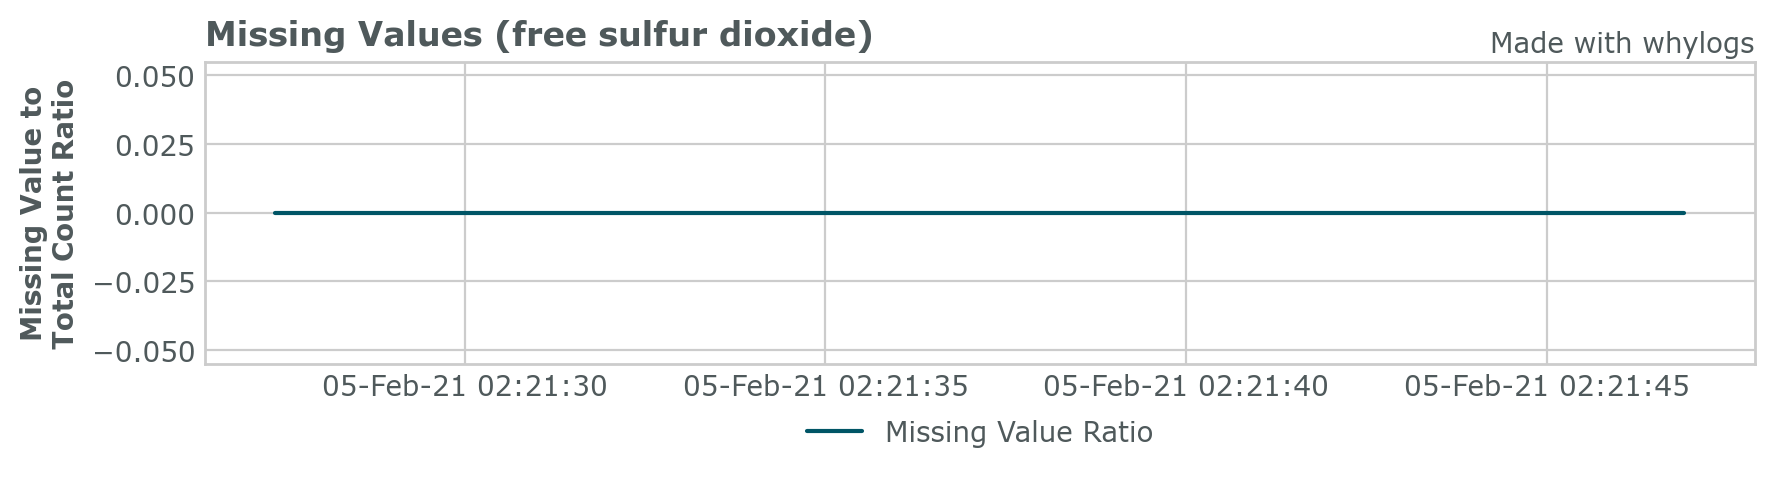

In [16]:
viz.plot_missing_values("free sulfur dioxide", ts_format="%d-%b-%y %H:%M:%S")

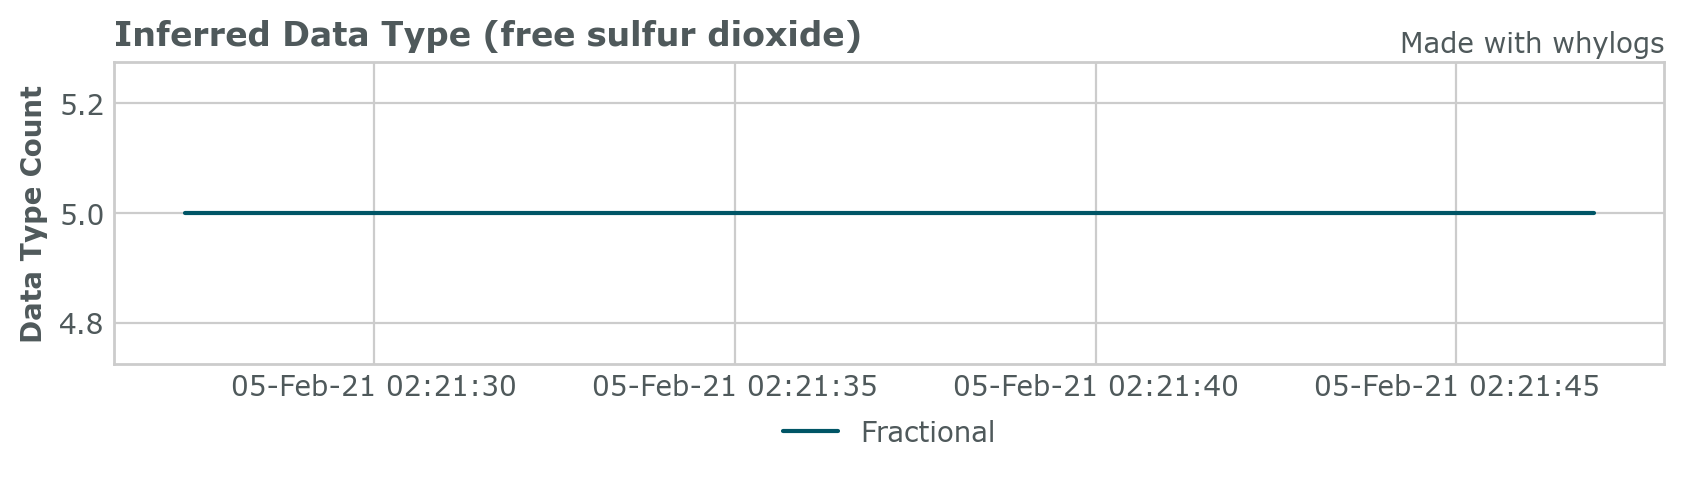

In [17]:
viz.plot_data_types("free sulfur dioxide", ts_format="%d-%b-%y %H:%M:%S")

We can also plot the mean error of each run for comparison.

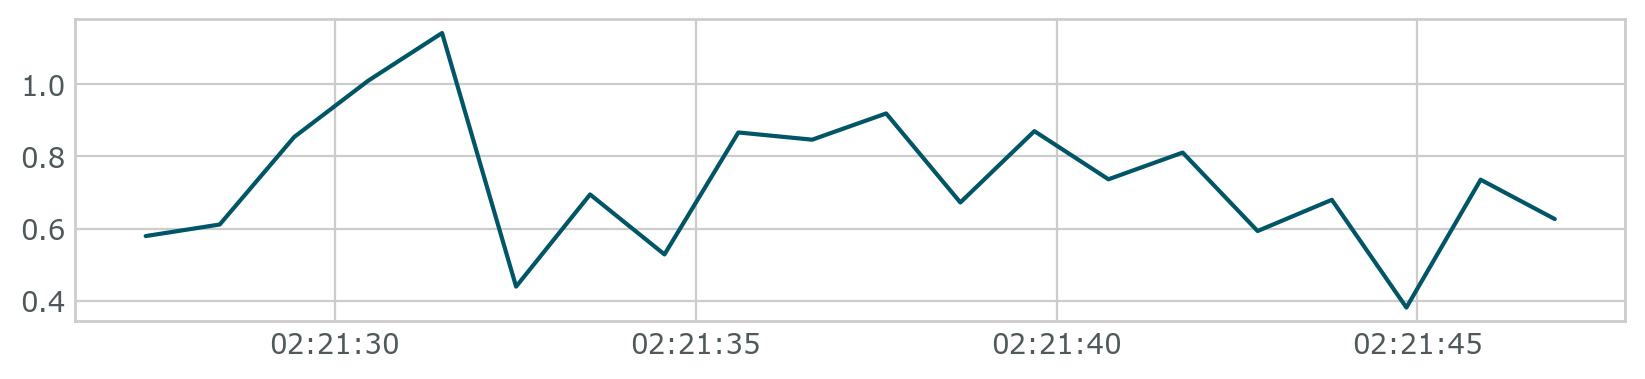

In [18]:
import matplotlib.pyplot as plt

plt.close('all')

runs = mlflow.search_runs(experiment.experiment_id)
plt.figure(figsize=(10,2))
plt.plot(runs['start_time'], runs['metrics.mae'])
plt.show()

With whylogs, collecting and visualizing data quality metrics at both training and inference time for your MLflow runs is made dead simple. These metrics can be invaluable when trying to debug model failures or optimize their performance.

whylogs data can be visualized in more complex ways. Check out [whylogs.viz](https://whylogs.readthedocs.io/en/latest/api/whylogs.viz.html) for details on the API.

In addition, you can also check out how **WhyLabs** can help you visualize data quality metrics by visiting [our sandbox](http://try.whylabsapp.com/). Feel free to reach out to our [slack channel](http://join.slack.whylabs.ai/) if you have any questions!